<a href="https://colab.research.google.com/github/james130625/notebook/blob/main/9_QMAO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<ipython-input-7-e93c90811192>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['QMAO'], data['QMAO_Signal'] = calculate_qmao(data)
<ipython-input-7-e93c90811192>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['QMAO'], data['QMAO_Signal'] = calculate_qmao(data)
<ipython-input-7-e93c90811192>:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas

Accuracy: 0.8482057955057305
Precision: 0.10147058823529412
Recall: 0.3190751445086705


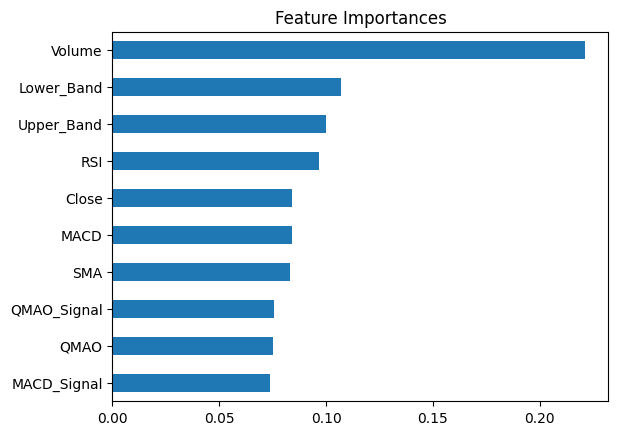

추천된 급등주 종목:
              Code  Close    Volume
Date                               
2024-05-30  051980   8910  12272620
2024-05-20  033790   6150  10569528
2024-02-14  047310  16640  10069904
2024-05-31  298830   6540   8315392
2024-04-02  005860   5250   8068773
2024-05-02  452190   6570   7742542
2024-05-24  297890   6680   6503864
2024-05-17  389140  11340   5389986
2024-05-29  323280   5680   5169241
2024-05-23  115450   7610   4906247
종목 코드: 051980
현재 단계: Eating
실시간 현재가: 9520
최근 종가: 9520
현재 추세: 상승 추세
52주 최고가: 10650.0
52주 최저가: 1358.0
52주 중간가격: 6004.0
1차 매수가: 2161.7780700609255
2차 매수가: 6882.907500000001
3차 매수가: 11604.036929939075
익절가: 11715.000000000002
손절가: 1290.1
종목 코드: 033790
현재 단계: Sleeping
실시간 현재가: 6670
최근 종가: 6670
현재 추세: 하락 추세
52주 최고가: 8070.0
52주 최저가: 970.0
52주 중간가격: 4520.0
1차 매수가: 3052.761826975874
2차 매수가: 5378.9
3차 매수가: 7705.038173024125
익절가: 8877.0
손절가: 921.5
종목 코드: 047310
현재 단계: Eating
실시간 현재가: 7210
최근 종가: 7210
현재 추세: 상승 추세
52주 최고가: 21700.0
52주 최저가: 5560.0
52주 중간가격: 13630.

<ipython-input-7-e93c90811192>:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data['QMAO'], stock_data['QMAO_Signal'] = calculate_qmao(stock_data)
<ipython-input-7-e93c90811192>:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data['QMAO'], stock_data['QMAO_Signal'] = calculate_qmao(stock_data)
<ipython-input-7-e93c90811192>:133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cavea

종목 코드: 297890
현재 단계: Sleeping
실시간 현재가: 6980
최근 종가: 6980
현재 추세: 하락 추세
52주 최고가: 7630.0
52주 최저가: 3832.0
52주 중간가격: 5731.0
1차 매수가: 6086.400439283946
2차 매수가: 6684.674999999999
3차 매수가: 7282.949560716053
익절가: 8393.0
손절가: 3640.3999999999996
종목 코드: 389140
현재 단계: Eating
실시간 현재가: 9500
최근 종가: 9500
현재 추세: 상승 추세
52주 최고가: 18950.0
52주 최저가: 6380.0
52주 중간가격: 12665.0
1차 매수가: 8112.730793681487
2차 매수가: 9595.0
3차 매수가: 11077.269206318511
익절가: 20845.0
손절가: 6061.0
종목 코드: 323280
현재 단계: Awakening
실시간 현재가: 6950
최근 종가: 6950
현재 추세: 상승 추세
52주 최고가: 7110.0
52주 최저가: 1945.0
52주 중간가격: 4527.5
1차 매수가: 4001.6683917066257
2차 매수가: 5867.229375000001
3차 매수가: 7732.790358293375
익절가: 7821.000000000001
손절가: 1847.75
종목 코드: 115450
현재 단계: Eating
실시간 현재가: 8470
최근 종가: 8470
현재 추세: 상승 추세
52주 최고가: 16490.0
52주 최저가: 2918.0
52주 중간가격: 9704.0
1차 매수가: 6393.449501634873
2차 매수가: 9013.2
3차 매수가: 11632.950498365128
익절가: 18139.0
손절가: 2772.1


In [7]:
# 필요 패키지 import
import FinanceDataReader as fdr
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# 한글 폰트 설정
plt.rcParams['font.family'] = 'NanumBarunGothic'

# 데이터 수집
kosdaq_list = fdr.StockListing('KOSDAQ')
start_date = '2023-01-02'
end_date = datetime.today().strftime('%Y-%m-%d')

# QMAO 계산 함수
def calculate_qmao(data):
    ma7 = data['Close'].rolling(window=7).mean()
    ma14 = data['Close'].rolling(window=14).mean()
    ma28 = data['Close'].rolling(window=28).mean()
    ma56 = data['Close'].rolling(window=56).mean()

    A = (ma7 - ma14) * (7 + 14) / 315 + (ma7 - ma28) * (7 + 28) / 315 + (ma7 - ma56) * (7 + 56) / 315
    B = (ma14 - ma28) * (14 + 28) / 315 + (ma14 - ma56) * (14 + 56) / 315
    C = (ma28 - ma56) * (28 + 56) / 315

    qmao = (A + B + C) / data['Close'] * 100
    signal_line = qmao.rolling(window=7).mean()

    return qmao, signal_line

# MACD 계산 함수
def calculate_macd(data):
    ema12 = data['Close'].ewm(span=12, adjust=False).mean()
    ema26 = data['Close'].ewm(span=26, adjust=False).mean()
    macd = ema12 - ema26
    signal_line = macd.ewm(span=9, adjust=False).mean()
    return macd, signal_line

# RSI 계산 함수
def calculate_rsi(data, window=14):
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# 볼린저 밴드 계산 함수
def calculate_bollinger_bands(data, window=20):
    sma = data['Close'].rolling(window=window).mean()
    std = data['Close'].rolling(window=window).std()
    upper_band = sma + (std * 2)
    lower_band = sma - (std * 2)
    return sma, upper_band, lower_band

# 급등주 레이블 생성 함수
def create_label(data, threshold=0.05):
    data['Label'] = (data['Close'].shift(-1) - data['Close']) / data['Close'] > threshold
    data['Label'] = data['Label'].astype(int)
    return data

# 각 종목의 데이터를 가져와서 전처리 및 특징 추출
filtered_stocks_data = []
for code in kosdaq_list['Code']:
    try:
        data = fdr.DataReader(code, start_date, end_date)
        if data['Close'].iloc[-1] >= 5000 and data['Close'].iloc[-1] <= 10000:
            data['QMAO'], data['QMAO_Signal'] = calculate_qmao(data)
            data['MACD'], data['MACD_Signal'] = calculate_macd(data)
            data['RSI'] = calculate_rsi(data)
            data['SMA'], data['Upper_Band'], data['Lower_Band'] = calculate_bollinger_bands(data)
            data = create_label(data)
            data['Code'] = code
            filtered_stocks_data.append(data)
    except Exception as e:
        print(f"Failed to process {code}: {e}")
        continue

# 데이터프레임으로 통합
all_data_df = pd.concat(filtered_stocks_data)

# 결측치 제거
all_data_df.dropna(inplace=True)

# 특징과 레이블 설정
features = ['Close', 'Volume', 'QMAO', 'QMAO_Signal', 'MACD', 'MACD_Signal', 'RSI', 'SMA', 'Upper_Band', 'Lower_Band']
X = all_data_df[features]
y = all_data_df['Label']

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 오버샘플링
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# 모델 학습
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_res, y_train_res)

# 예측 및 평가
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))

# 중요 특징 시각화
feature_importances = pd.Series(model.feature_importances_, index=features)
feature_importances.sort_values().plot(kind='barh')
plt.title('Feature Importances')
plt.show()

# 급등주 예측
predicted_data = all_data_df.copy()
predicted_data['Prediction'] = model.predict(X)

# 예측된 급등주 중 상위 10개 종목 추천
predicted_gainers = predicted_data[predicted_data['Prediction'] == 1]
top_10_gainers = predicted_gainers.groupby('Code').tail(1).sort_values(by='Volume', ascending=False).head(10)

print("추천된 급등주 종목:")
print(top_10_gainers[['Code', 'Close', 'Volume']])

# 상위 10개 종목의 상세 정보 출력
for ticker in top_10_gainers['Code']:
    stock_data = fdr.DataReader(ticker, start_date, end_date)
    stock_data['QMAO'], stock_data['QMAO_Signal'] = calculate_qmao(stock_data)
    stock_data['MACD'], stock_data['MACD_Signal'] = calculate_macd(stock_data)
    stock_data['RSI'] = calculate_rsi(stock_data)
    stock_data['SMA'], stock_data['Upper_Band'], stock_data['Lower_Band'] = calculate_bollinger_bands(stock_data)

    # 최신 데이터 포인트의 단계 표시
    short_ma = stock_data['QMAO']
    long_ma = stock_data['QMAO_Signal']
    current_phase = 'Sleeping'
    if short_ma.iloc[-1] > long_ma.iloc[-1]:
        current_phase = 'Awakening' if short_ma.iloc[-2] <= long_ma.iloc[-2] else 'Eating'

    # 실시간 가격 가져오기 (예시로 최근 종가 사용)
    current_price = stock_data['Close'].iloc[-1]

    # 추가 메트릭 계산
    latest_close = stock_data['Close'].iloc[-1]
    current_trend = "상승 추세" if stock_data['QMAO'].iloc[-1] > stock_data['QMAO_Signal'].iloc[-1] else "하락 추세"
    fifty_two_week_high = stock_data['Close'].rolling(window=252).max().iloc[-1]
    fifty_two_week_low = stock_data['Close'].rolling(window=252).min().iloc[-1]
    fifty_two_week_mid = (fifty_two_week_high + fifty_two_week_low) / 2

    # 피라미딩 매수 단계 정의 (MACD, RSI, 볼린저 밴드를 기준으로)
    first_buy_target = stock_data['Lower_Band'].iloc[-1]  # 볼린저 밴드 하단
    second_buy_target = stock_data['SMA'].iloc[-1]  # 볼린저 밴드 중간
    third_buy_target = stock_data['Upper_Band'].iloc[-1]  # 볼린저 밴드 상단
    profit_target = fifty_two_week_high * 1.1  # 익절가
    stop_loss = fifty_two_week_low * 0.95  # 손절가

    if stock_data['RSI'].iloc[-1] < 30:
        first_buy_target *= 0.95
        second_buy_target *= 0.95
        third_buy_target *= 0.95
    elif stock_data['RSI'].iloc[-1] > 70:
        first_buy_target *= 1.05
        second_buy_target *= 1.05
        third_buy_target *= 1.05

    if stock_data['MACD'].iloc[-1] > stock_data['MACD_Signal'].iloc[-1]:
        first_buy_target *= 1.05
        second_buy_target *= 1.05
        third_buy_target *= 1.05
    else:
        first_buy_target *= 0.95
        second_buy_target *= 0.95
        third_buy_target *= 0.95

    # 결과 표시
    print(f"종목 코드: {ticker}")
    print("현재 단계:", current_phase)
    print("실시간 현재가:", current_price)
    print("최근 종가:", latest_close)
    print("현재 추세:", current_trend)
    print("52주 최고가:", fifty_two_week_high)
    print("52주 최저가:", fifty_two_week_low)
    print("52주 중간가격:", fifty_two_week_mid)
    print("1차 매수가:", first_buy_target)
    print("2차 매수가:", second_buy_target)
    print("3차 매수가:", third_buy_target)
    print("익절가:", profit_target)
    print("손절가:", stop_loss)
    print("="*50)
